I refered 'GAN Introduction' of  Nanashi-san.
https://www.kaggle.com/code/jesucristo/gan-introduction/notebook
Thank you very much for sharing impressive introduction.

For the first time, I tried GANs. So it is not enough and I need more learning. I appreciate it if I can get your feedback.

In my notebook 'How can we detect proliferative retinopathy ?'(https://www.kaggle.com/code/sasakitetsuya/how-can-we-detect-proliferative-retinopathy),
I tried detection model for proliferative retinopathy. But it is not still enough and need some improvement.

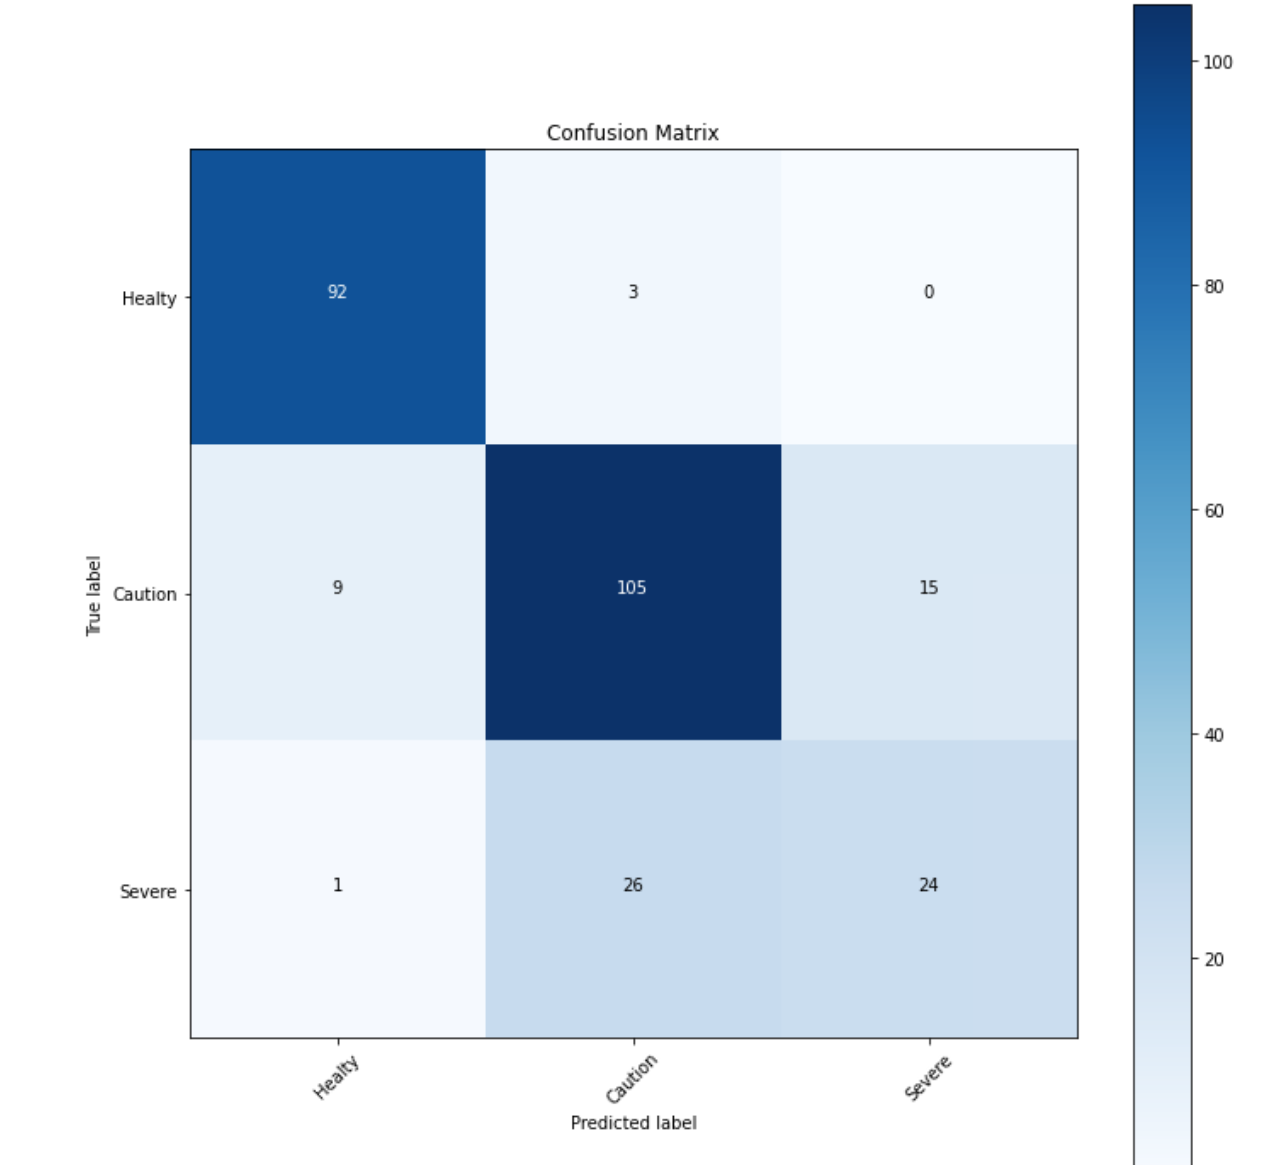

Especially, 'Recall' of 'Caution' and 'Severe' condition is low, although the most important thing is how we do not miss 'Caution' and 'Severe'. On the other hand, I happened to read the article 'Data augmentation using generative adversarial networks (CycleGAN) to improve generalizability in CT segmentation tasks'(https://www.nature.com/articles/s41598-019-52737-x). According to this article,

"Labeled medical imaging data is scarce and expensive to generate. To achieve generalizable deep learning models large amounts of data are needed. Standard data augmentation is a method to increase generalizability and is routinely performed. Generative adversarial networks offer a novel method for data augmentation."

Actually, this kind of technology is still expensive for small hospitals, some area or countries etc... and it may cause health gap. But it means that if this kind of tech spread widely, it will reduce health gap, improve the productivity of medical examination and save a lot of people.

So I tried GAN to confirm how it works, although it is still not enough and I need more learning....

# Importing

In [ ]:
import os
print(os.listdir("../input/diabetic-retinopathy-dataset/"))

In [ ]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

import time
import random
import glob

import cv2
from PIL import Image

# Sample Images

* Healthy

In [ ]:
PATH1 = '../input/diabetic-retinopathy-dataset/Healthy/'
images = os.listdir(PATH1)
print(f'There are {len(os.listdir(PATH1))} pictures of Healthy.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH1)))
    img = plt.imread(PATH1 + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

* Severe

In [ ]:
PATH2 = '../input/diabetic-retinopathy-dataset/Severe DR/'
images2 = os.listdir(PATH2)
print(f'There are {len(os.listdir(PATH2))} pictures of severeDR.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH2)))
    img = plt.imread(PATH2 + images2[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images2[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Image Preprocessing

In [ ]:
batch_size = 32
batchSize = 64
imageSize = 64

# 64x64 images!
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('../input/diabetic-retinopathy-dataset/', transform=transform)

dataloader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

imgs, label = next(iter(dataloader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [ ]:
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder('../input/diabetic-retinopathy-dataset/', transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [ ]:
train_data

In [ ]:
for i in range(5):
    plt.imshow(imgs[i])
    plt.show()

# Weights

In [ ]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator

In [ ]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Tanh()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output

netG = G()
netG.apply(weights_init)

# Discriminator

In [ ]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output.view(-1)
    
netD = D()
netD.apply(weights_init)

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

    
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

# Training

In [ ]:
!mkdir results
!ls

In [ ]:
EPOCH = 1
LR = 0.0001
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))

In [ ]:
for epoch in range(EPOCH):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        
        real,_ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD(input)
        errD_real = criterion(output, target)
        
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target)
        
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        
        print('[%d/%d][%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, EPOCH, i, len(dataloader), errD.item(), errG.item()))
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./results", normalize=True)
            fake = netG(noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize=True)

In [ ]:
batch_size = 32
LR_G = 0.0005
LR_D = 0.0001

beta1 = 0.5
epochs = 100

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []

In [ ]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

In [ ]:
for epoch in range(epochs):
    
    start = time.time()
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
    plot_loss (G_losses, D_losses, epoch)
    G_losses = []
    D_losses = []
    if epoch % 10 == 0:
        show_generated_img()

    epoch_time.append(time.time()- start)
    
#             valid_image = netG(fixed_noise)